## <center> **Прогнозирование биологического ответа**

#### Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776).

В качестве метрики будем использовать F1-score.

Обучим две модели: логистическую регрессию и случайный лес. Далее сделаем подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna).

In [ ]:
# Устанавливаем необходимые библиотеки для оптимизации гиперпараметров
# !pip install hyperopt
# !pip install optuna

In [5]:
import pandas as pd #для чтения и обработки данных
import numpy as np #для матричных вычислений
from sklearn import tree, ensemble #деревья и ансамбли
from sklearn.linear_model import LogisticRegression #логистическая регрессия
from sklearn import metrics #для метрик
import hyperopt, optuna #для оптимизации гиперпараметров
from hyperopt import hp, fmin, tpe, Trials #для оптимизации гиперпараметров
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV #для оптимизации гиперпараметров
from sklearn.model_selection import train_test_split, cross_val_score #для разделения датасета на выборки
import seaborn as sns #для визуализации
import matplotlib.pyplot as plt #для визуализации


In [6]:
data = pd.read_csv('train_sem09.csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; 
Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3751 entries, 0 to 3750
Columns: 1777 entries, Activity to D1776
dtypes: float64(942), int64(835)
memory usage: 50.9 MB


Все признаки числовые

In [19]:
data.isna().sum().sort_values(ascending=True)

Activity    0
D1190       0
D1189       0
D1188       0
D1187       0
           ..
D586        0
D585        0
D584        0
D595        0
D1776       0
Length: 1777, dtype: int64

Пропусков в данных нет

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Activity,3751.0,0.542255,0.498278,0.000000,0.000000,1.000000,1.000000,1.000000
D1,3751.0,0.076948,0.079989,0.000000,0.033300,0.066700,0.100000,1.000000
D2,3751.0,0.592436,0.105860,0.282128,0.517811,0.585989,0.668395,0.964381
D3,3751.0,0.068142,0.078414,0.000000,0.000000,0.050000,0.100000,0.950000
D4,3751.0,0.038990,0.115885,0.000000,0.000000,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...
D1772,3751.0,0.016796,0.128522,0.000000,0.000000,0.000000,0.000000,1.000000
D1773,3751.0,0.012263,0.110074,0.000000,0.000000,0.000000,0.000000,1.000000
D1774,3751.0,0.011730,0.107683,0.000000,0.000000,0.000000,0.000000,1.000000
D1775,3751.0,0.020261,0.140911,0.000000,0.000000,0.000000,0.000000,1.000000


Все признаки действительно предобработаны и нормализованы

1    0.542255
0    0.457745
Name: Activity, dtype: float64

<AxesSubplot: xlabel='Activity', ylabel='count'>

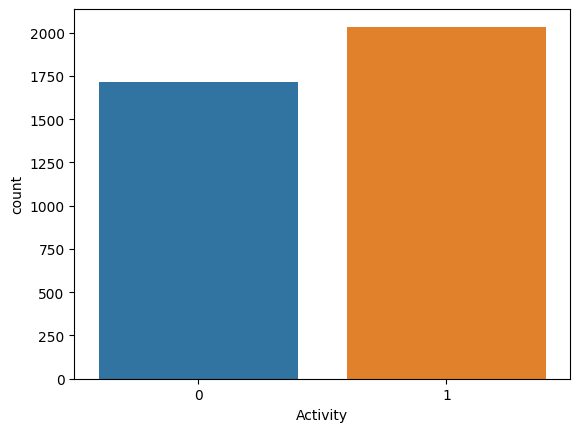

In [22]:
display(data.Activity.value_counts(normalize=True))
sns.countplot(data, x='Activity')

Выборка сбалансированная, разделим датасет на тренировочную и тестовую выборки

In [7]:
random_state = 42
X, y = data.drop('Activity', axis=1), data.Activity
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3000, 1776) (751, 1776) (3000,) (751,)


Обучим модели логистической регрессии и случайого леса.  
Зафиксируем метрику f-1 score для базовых гиперпараметров на тестовой выборке

In [23]:
#Создаем объект класса логистическая регрессия
log_reg = LogisticRegression(max_iter = 1000)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
# Предсказываем значения на тренировочной и тестовой выборках
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)
print('f1_score на тренировочном наборе модель логистической регрессии: {:.2f}'
      .format(metrics.f1_score(y_train, y_train_pred)))
print('f1_score на тестовом наборе модель логистической регрессии: {:.2f}'
      .format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тренировочном наборе модель случайного леса: 0.89
f1_score на тестовом наборе модель логистической регрессии: 0.79


In [24]:
log_reg.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Параметры, которые нас интересуют:  
- тип регуляризации ('l1' или 'l2')  
- алгоритм оптимизации ('liblinear', 'saga', 'lbfgs', 'sag')   
- уровень силы регурялизации ('C')

In [22]:
#Создаем объект класса логистическая регрессия
model_rf = ensemble.RandomForestClassifier()
#Обучаем модель, минимизируя logloss
model_rf.fit(X_train, y_train)
# Предсказываем значения на тренировочной и тестовой выборках
y_train_pred = model_rf.predict(X_train)
y_test_pred = model_rf.predict(X_test)

print('f1_score на тренировочном наборе модель случайного леса: {:.2f}'
      .format(metrics.f1_score(y_train, y_train_pred)))
print('f1_score на тестовом наборе модель случайного леса: {:.2f}'
      .format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тренировочном наборе модель случайного леса: 1.00
f1_score на тестовом наборе модель случайного леса: 0.83


In [21]:
model_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Для случайного леса параметров гораздо больше:   
- критерий информативности ('gini', 'entropy', 'log_loss')  
- максимальная глубина дерева ('max_depth')   
- максимальное количество признаков ('max_features': ['sqrt', 'log2'])
- минимальное количество листьев для деления ветки ('min_samples_leaf')
- количество деревьев в лесу ('n_estimators')

Метрика случайного леса гораздо лучше, однако модель переобучена.  
Поскольку алгоритм GridSearchCV довольно ресурсозатратный, к тому же он не обладает необходимой нам гибкостью, поэтому для экономии времени проведём оптимизацию на модели линейной регрессии и попробуем выяснить, сможем ли мы её улучшить, подобрав оптимальные гиперпараметры.

#### <center> Оптимизация гиперпараметров с помощью **GridSearchCV**

In [26]:
param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.5, 0.7, 0.9, 1]}
              ]
grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=random_state, max_iter=1000), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train, y_train) 

y_train_pred = grid_search.predict(X_train)
print('f1_score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Наилучшие значения гиперпараметров: {}'.format(grid_search.best_params_))

CPU times: total: 4.27 s
Wall time: 2h 58min 12s
f1_score на тренировочном наборе: 0.87
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'C': 0.9, 'penalty': 'l1', 'solver': 'liblinear'}


У нас не получилось улучшить метрики с помощью GridSearchCV. Недостаток метода заключается в том, что он чувствителен к заданному заранее ограниченному набору параметров. Видимо, комбинации параметров были выбраны неудачно. 

#### <center> Оптимизация гиперпараметров с помощью **RandomizedSearchCV**

In [27]:
param_distributions = {'n_estimators': list(np.linspace(100, 300, 5, dtype=int)),
              'min_samples_leaf': [2, 4, 6],
              'max_depth': list(np.linspace(5, 20, 5, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train, y_train) 
y_train_pred = random_search_forest.predict(X_train)
print('f1_score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: total: 11.2 s
Wall time: 7min 26s
f1_score на тренировочном наборе: 0.98
f1_score на тестовом наборе: 0.83
Наилучшие значения гиперпараметров: {'n_estimators': 200, 'min_samples_leaf': 2, 'max_depth': 16}


У нас также не получилось улучшить метрику модели случайного леса с помощью RandomizedSearchCV, но при этом мы затратили гораздо меньше времени, чем на методе GridSearchCV.  
Ограничение глубины помогло немного нивелировать переобучение, однако глубина дерева 16 - достаточно высокая. Вероятно, чтобы снизить разброс модели (вероятность ошибки II рода), придется пожертвовать показателем смещения (вероятности ошибки I рода).

#### <center> Оптимизация гиперпараметров с помощью **Hyperopt**

In [11]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.randint('n_estimators', 100, 300),
       'max_depth' : hp.randint('max_depth', 5, 15),
       'min_samples_leaf': hp.randint('min_samples_leaf', 2, 15)
      }

In [12]:
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': params['n_estimators'], 
              'max_depth': params['max_depth'], 
             'min_samples_leaf': params['min_samples_leaf']
              }
  
    # используем эту комбинацию для построения модели
    model_rf = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model_rf, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [13]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 20/20 [13:45<00:00, 41.26s/trial, best loss: -0.806996036480359]
Наилучшие значения гиперпараметров {'max_depth': 12, 'min_samples_leaf': 2, 'n_estimators': 195}
CPU times: total: 4 s
Wall time: 13min 45s


In [14]:
model_rf = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model_rf.fit(X_train, y_train)
y_train_pred = model_rf.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = model_rf.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.95
f1_score на тестовом наборе: 0.82


У нас так же не удалось улучшить метрику, однако понижение глубины дерева привело к снижению переобученности с наименьшей потерей качества метрики.

#### <center> Оптимизация гиперпараметров с помощью **Optuna**

In [15]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 300, 1)
  max_depth = trial.suggest_int('max_depth', 5, 15, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model_rf = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model_rf.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model_rf.predict(X_train))

  return score

In [16]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-07-05 14:27:36,348] A new study created in memory with name: RandomForestClassifier
[I 2023-07-05 14:28:01,232] Trial 0 finished with value: 0.9015833592052157 and parameters: {'n_estimators': 252, 'max_depth': 15, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.9015833592052157.
[I 2023-07-05 14:28:17,082] Trial 1 finished with value: 0.9049858889934148 and parameters: {'n_estimators': 203, 'max_depth': 9, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9049858889934148.
[I 2023-07-05 14:28:39,356] Trial 2 finished with value: 0.9136802742287317 and parameters: {'n_estimators': 287, 'max_depth': 9, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9136802742287317.
[I 2023-07-05 14:28:52,810] Trial 3 finished with value: 0.8313176320814767 and parameters: {'n_estimators': 250, 'max_depth': 6, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9136802742287317.
[I 2023-07-05 14:29:20,889] Trial 4 finished with value: 0.9548427281220804 and parameters: {'n_est

CPU times: total: 3min 6s
Wall time: 6min 42s


In [17]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 229, 'max_depth': 14, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.97


In [18]:
# рассчитаем точность для тестовой выборки
model_rf = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model_rf.fit(X_train, y_train)

y_test_pred = model_rf.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.84


In [19]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

In [25]:
optuna.visualization.plot_param_importances(study, target_name="f1_score")

Оптимизация гиперпараметров с помощью билиотеки Optuna оказалась самой эффективной, мы добились высокого показателя целевой метрики за самое быстрое время. Однако стоит отметить, что ни один набор гиперпараметров не позволил нам избежать переобучения модели. Это говорит о то, что нужно очень внимательно принимать решение по диапазону параметров, которые мы задаём для подбора. Последний график наглядно подтверждает, что глубина дерева для алгоритма случайного леса является определеяющей.

* попробуем подобрать оптимальные гиперпараметры для случайного леса, ограничив верхний диапазон глубин дерева значением 10

In [29]:
def optuna_rf_2(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 300, 1)
  max_depth = trial.suggest_int('max_depth', 5, 10, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model_rf = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model_rf.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model_rf.predict(X_train))

  return score

In [31]:
study = optuna.create_study(study_name="RandomForestClassifier_v2",direction="maximize")
study.optimize(optuna_rf_2, n_trials=20)

[I 2023-07-05 16:01:29,737] A new study created in memory with name: no-name-c92764ee-df0a-4707-9501-893c99d46432
[I 2023-07-05 16:01:41,312] Trial 0 finished with value: 0.8506758880855078 and parameters: {'n_estimators': 143, 'max_depth': 8, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8506758880855078.
[I 2023-07-05 16:01:51,752] Trial 1 finished with value: 0.7944073721004131 and parameters: {'n_estimators': 161, 'max_depth': 5, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8506758880855078.
[I 2023-07-05 16:02:06,275] Trial 2 finished with value: 0.8532488114104596 and parameters: {'n_estimators': 149, 'max_depth': 7, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.8532488114104596.
[I 2023-07-05 16:02:12,869] Trial 3 finished with value: 0.8185573562122657 and parameters: {'n_estimators': 115, 'max_depth': 6, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.8532488114104596.
[I 2023-07-05 16:02:22,197] Trial 4 finished with value: 0.796437659033079 an

In [32]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 264, 'max_depth': 10, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.93


In [33]:
model_rf = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model_rf.fit(X_train, y_train)

y_test_pred = model_rf.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.83
